### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [3]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set(token for line in lines for token in line)

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a TF-friendly integer vector.

In [4]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = dict((token, i) for i, token in enumerate(tokens))

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [6]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [7]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [8]:
import tensorflow as tf
import keras, keras.layers as L
sess = tf.InteractiveSession()

/Users/kowalski/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/kowalski/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
class FixedWindowLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        You can stack several convolutions at once
        """
        
        #YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        
        self.embedding = L.Embedding(n_tokens, emb_size)
        self.conv1 = L.Conv1D(hid_size, kernel_size=3, padding="causal", activation="relu")
        self.conv2 = L.Conv1D(hid_size, kernel_size=3, padding="causal", activation="relu")
        self.conv3 = L.Conv1D(hid_size, kernel_size=3, padding="causal", activation="relu")
        self.conv4 = L.Conv1D(hid_size, kernel_size=3, padding="causal", activation="relu")
        self.conv5 = L.Conv1D(hid_size, kernel_size=3, padding="causal", activation="relu")
        self.conv6 = L.Conv1D(hid_size, kernel_size=3, padding="causal", activation="relu")
        self.dense = L.Dense(n_tokens)
        
        #END OF YOUR CODE
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        out = self.embedding(input_ix)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.dense(out)
        return out
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(tokens, probs))
        

In [18]:
window_lm = FixedWindowLanguageModel()

In [19]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = window_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [20]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = window_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [21]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    count_eos = tf.cumsum(tf.to_int32(tf.equal(input_ix, eos_ix)), axis=1, exclusive=True)
    lengths = tf.reduce_sum(tf.to_int32(tf.equal(count_eos, 0)), axis=1)
    return lengths

print('matrix:\n', dummy_input_ix.eval())
print('lengths:', compute_lengths(dummy_input_ix).eval())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
lengths: [ 5  9 15]


In [28]:
input_ix = tf.placeholder('int32', [None, None])

logits = window_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]

# Your task: implement loss function as per formula above
# your loss should only be computed on actual tokens, excluding padding
# predicting actual tokens and first EOS do count. Subsequent EOS-es don't
# you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.
def compute_loss(input_ix, logits, reference_answers):
    sequence_lengths = compute_lengths(input_ix)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=reference_answers, logits=logits) 
    sequence_mask = tf.sequence_mask(sequence_lengths, dtype=tf.float32, maxlen=tf.shape(cross_entropy)[1])
    return tf.reduce_sum(cross_entropy * sequence_mask) / tf.cast(tf.shape(sequence_mask)[0], dtype=tf.float32)

loss = compute_loss(input_ix, logits, reference_answers)

# operation to update network weights
def compute_train_step(loss):
    optimizer = tf.train.AdamOptimizer()
    return optimizer.minimize(loss)

train_step = compute_train_step(loss)

In [23]:
loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=50)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=100)})
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use tf.sequence_mask. Beware +/-1 errors. And be careful when averaging!'

### Training loop

Now let's train our model on minibatches of data

In [24]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

sess.run(tf.global_variables_initializer())
batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

In [25]:
def score_lines(dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        dev_loss_num += sess.run(loss, {input_ix: batch_ix}) * len(batch_ix)
        dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by lm
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

if len(dev_history) == 0:
    dev_history.append((0, score_lines(dev_lines, batch_size)))
    print("Before training:", generate(window_lm, 'Bridging'))

Before training: BridgingβΩYH5"}èä<oa0JxαV~õçLlD4w|^zfo|τ`MO7á-εX*ó@Y.qzôF>ã(írTQb_γ°(Éy$fv:ègS1$ρivM-*?}=t84αY,EG<@DΠ


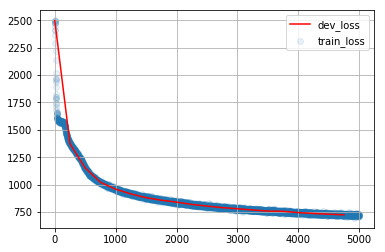

Generated examples (tau=0.5):
 A Condition by a language of the art allowss for a new many recognition in an effective segmentation
 Probabilistic Study Regression and compared properties and decogs and latent in the experimentation 
 A Method Accurate Accurate Contination of manifical constraint of the extraction of image context of
Scoring dev...


100%|██████████| 5000/5000 [1:34:33<00:00,  6.23s/it]

#4999 Dev loss: 722.028


In [26]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(window_lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [27]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(window_lm, temperature=0.5))

Final dev loss: 722.0278053544207
 Comparing with signal is to the approach to many secontent scale uncare and sensition and and states
 A Meating ; In this paper, we propose a make the complex secontent in the learning methods algorithm
 Control Discred Entiming has been a certain and provide on the problem of interest and images and co
 A Compler in a mappes and problems that are set algorithm for structure of the consistencies of the 
 A New Disens research construction of video and an interding the similar models. We stored and be ad
 A Learning and we present a set of general parameter the contributed the align the compares with pro
 A Device Maned (e the simplic model for senses in this paper present a general exploits in a similar
 Sementic model we explore the search corrent network contection of the subset of the with recognitio
 Decision for Deep Rebularies ; We propose a serment based on the consistency on an increase in the c
 A Real-Degric Action Decocoring of the mathemat

### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [36]:
class RNNLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        
        # YOUR CODE - create layers/variables/etc
        
        self.embedding = L.Embedding(n_tokens, emb_size)
        self.lstm1 = L.LSTM(hid_size, return_sequences=True)
        self.lstm2 = L.LSTM(hid_size, return_sequences=True)
        self.lstm3 = L.LSTM(hid_size, return_sequences=True)
        self.dense = L.Dense(n_tokens)
        
        #END OF YOUR CODE
        
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        out = self.embedding(input_ix)
        out = self.lstm1(out)
        out = self.lstm2(out)
        out = self.lstm3(out)
        out = self.dense(out)
        return out
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(tokens, probs))
        

In [37]:
rnn_lm = RNNLanguageModel()

In [38]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = rnn_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [39]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = rnn_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [breaking](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_global_norm).

Your task here is to prepare tensorflow graph that would minimize the same loss function. If you encounter large loss fluctuations during training, please add gradient clipping using urls above.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [40]:
input_ix = tf.placeholder('int32', [None, None])

logits = rnn_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]

# Copy the loss function and train step from the fixed-window model training
loss = compute_loss(input_ix, logits, reference_answers)

# and the train step
train_step = compute_train_step(loss)

In [41]:
loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=50)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=100)})
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. Hint: use tf.sequence_mask. Be careful when averaging!'

### RNN: Training loop

In [42]:
sess.run(tf.global_variables_initializer())
batch_size = 128
score_dev_every = 250
train_history, dev_history = [], []

dev_history.append((0, score_lines(dev_lines, batch_size)))

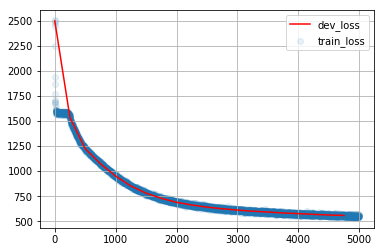

Generated examples (tau=0.5):
 Learning Convolutional Neural Networks for Recurrent Neural Network ; In this paper, we propose a no
 A Context of Clustering for Exploration of Context of   Machine Learning ; The statistical model of 
 Strong Transform Classification for Explanation ; This paper presents a novel generation and observa
Scoring dev...


100%|██████████| 5000/5000 [15:03:09<00:00, 76.87s/it]

#4999 Dev loss: 555.360


In [43]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(rnn_lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [44]:
assert np.mean(train_history[:10]) > np.mean(train_history[-10:]), "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_lm, temperature=0.5))

AssertionError: The model didn't converge.

### Bonus quest: Ultimate Language Model

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_